In [4]:
# import sys
# sys.path.append("../")
# sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.backend import clear_session
import bayesflow as beef
import pandas as pd
import pickle

# from experiments import NonStationaryDDMExperiment
# from models import RandomWalkDDM, MixtureRandomWalkDDM, LevyFlightDDM, RegimeSwitchingDDM
from helpers import get_setup
from configurations import model_names

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
from scipy.stats import median_abs_deviation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

from helpers import get_setup
from configurations import model_names

NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

In [2]:
with open('data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)

In [4]:
setup = [get_setup(names, "smoothing") for names in model_names]
models = [model[0] for model in setup]
trainers = [trainer[1] for trainer in setup]

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from checkpoints/smoothing_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Performing 2 pilot runs with t

In [5]:
models

In [3]:
get_setup(model_names[0], skip_checks=True)

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from checkpoints/smoothing_random_walk_ddm/ckpt-75


(<models.RandomWalkDDM at 0x110b0cfd0>,
 <experiments.NonStationaryDDMExperiment at 0x2a78666d0>)

In [9]:
setup = [get_setup(names, "smoothing") for names in model_names]
models = [model[0] for model in setup]
trainers = [trainer[1] for trainer in setup]

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from checkpoints/smoothing_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Performing 2 pilot runs with t

In [3]:
models

In [ ]:
NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

# Fit models

In [ ]:
which = 6
data = pd.read_csv('../data/data_color_discrimination.csv')
person_data = data.loc[data.id == which]
person_rt = np.where(person_data['correct'] == 0, -person_data['rt'], person_data['rt'])[None, :, None]
person_rt.shape

In [ ]:
samples_z = mrw_ddm_exp.amortizer.sample({'summary_conditions': person_rt}, NUM_SAMPLES)

In [ ]:
local_post = samples_z['local_samples'] * mrw_ddm.local_prior_stds + mrw_ddm.local_prior_means
local_post_t = np.transpose(local_post, (1, 0, 2))

In [ ]:
idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
pred_data = np.abs(mrw_ddm.likelihood(local_post_t[idx, :, :])['sim_data'])

In [ ]:
pred_df = pd.DataFrame({
    'speed_condition': np.tile(person_data['speed_condition'], NUM_RESIMULATIONS),
    'difficulty': np.tile(person_data['difficulty'], NUM_RESIMULATIONS),
    'rt': pred_data.flatten(),
    })

In [ ]:
grouped = pred_df.groupby(['difficulty', 'speed_condition'])
pred_summary = grouped.agg({
    'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
})
pred_summary = pred_summary.reset_index(drop=False)
pred_summary.columns = ['difficulty', 'speed_condition', 'median', 'mad']
pred_summary

In [ ]:
grouped = data.groupby(['speed_condition', 'difficulty'])
true_summary = grouped.agg({
    'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
})
true_summary = true_summary.reset_index(drop=False)
true_summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']

In [ ]:
[true_summary, pred_summary]

In [ ]:
bar_width = 0.1

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(
    pred_summary.loc[pred_summary.speed_condition == 0, 'difficulty'] * 2 - bar_width,
    pred_summary.loc[pred_summary.speed_condition == 0, 'median'],
    color='maroon', alpha=0.8, label="Mixture random Walk DDM"
)
ax[0].errorbar(
    pred_summary.loc[pred_summary.speed_condition == 0, 'difficulty'] * 2 - bar_width,
    pred_summary.loc[pred_summary.speed_condition == 0, 'median'],
    yerr=pred_summary.loc[pred_summary.speed_condition == 0, 'mad'],
    fmt='none', capsize=5, elinewidth=1,
    color='maroon', alpha=0.8
    )
ax[0].scatter(
    true_summary.loc[true_summary.speed_condition == 0, 'difficulty'] * 2 + bar_width,
    true_summary.loc[true_summary.speed_condition == 0, 'median'],
    color='black', alpha=0.8, label="Empiric"
)
ax[0].errorbar(
    true_summary.loc[true_summary.speed_condition == 0, 'difficulty'] * 2 + bar_width,
    true_summary.loc[true_summary.speed_condition == 0, 'median'],
    yerr=true_summary.loc[true_summary.speed_condition == 0, 'mad'],
    fmt='none', capsize=5, elinewidth=1,
    color='black', alpha=0.8
    )
ax[1].scatter(
    pred_summary.loc[pred_summary.speed_condition == 1, 'difficulty'] * 2 - bar_width,
    pred_summary.loc[pred_summary.speed_condition == 1, 'median'],
    color='maroon', alpha=0.8, label="Mixture random Walk DDM"
)
ax[1].errorbar(
    pred_summary.loc[pred_summary.speed_condition == 1, 'difficulty'] * 2 - bar_width,
    pred_summary.loc[pred_summary.speed_condition == 1, 'median'],
    yerr=pred_summary.loc[pred_summary.speed_condition == 1, 'mad'],
    fmt='none', capsize=5, elinewidth=1,
    color='maroon', alpha=0.8
    )
ax[1].scatter(
    true_summary.loc[true_summary.speed_condition == 1, 'difficulty'] * 2 + bar_width,
    true_summary.loc[true_summary.speed_condition == 1, 'median'],
    color='black', alpha=0.8, label="Empiric"
)
ax[1].errorbar(
    true_summary.loc[true_summary.speed_condition == 1, 'difficulty'] * 2 + bar_width,
    true_summary.loc[true_summary.speed_condition == 1, 'median'],
    yerr=true_summary.loc[true_summary.speed_condition == 1, 'mad'],
    fmt='none', capsize=5, elinewidth=1,
    color='black', alpha=0.8
    )

ax[0].set_title("Accuracy Condition", fontsize=FONT_SIZE_1)
ax[1].set_title("Speed Condition", fontsize=FONT_SIZE_1)

x_labels = ['1', '2', '3', '4']
x_positions = [0, 2, 4, 6]

ax[0].set_xticks(x_positions, x_labels)
ax[1].set_xticks(x_positions, x_labels)

ax[0].set_ylim([0.3, 1.6])
ax[1].set_ylim([0.3, 1.6])


ax[0].tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
ax[1].tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
ax[0].set_ylabel("Response Time", fontsize=FONT_SIZE_2)
ax[0].set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)
ax[1].set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)


fig.subplots_adjust(hspace=0.5)

# legend
handles = [
    Line2D(
        xdata=[], ydata=[], marker='o', markersize=5,
        color='maroon', alpha=0.8,  label="Mixture random Walk DDM"
        ),
    Line2D(
        xdata=[], ydata=[], marker='o', markersize=5,
        color='black', alpha=0.8,  label="Empiric"
        )
    ]

fig.legend(
    handles,
    ["Mixture random walk DDM", "Empiric"],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.1),
    loc="center", ncol=2
    )
sns.despine()
fig.tight_layout()

In [6]:
with open('data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)

In [13]:
def plot_parameter_trajectory(person_data, local_samples, lw=2):
    # get conditions
    condition = person_data['speed_condition'].to_numpy()
    idx_speed = []
    if condition[0] == 1:
        idx_speed.append([0])
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed = np.concatenate(idx_speed)
    else:
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed.append([NUM_OBS])
        idx_speed = np.concatenate(idx_speed)
    # calculate posterior median and mad
    post_median = np.median(local_samples, axis=1)
    post_mad = median_abs_deviation(local_samples, axis=1)
    # plot
    fig, axarr = plt.subplots(3, 1, figsize=(18, 14))
    for i, ax in enumerate(axarr.flat):
        # parameter trajectory
        ax.plot(
            range(NUM_OBS),
            post_median[:, i], 
            color='maroon', alpha=1.0, lw=lw, label="Posterior median"
            )
        ax.fill_between(
            range(NUM_OBS),
            post_median[:, i] - post_mad[:, i],
            post_median[:, i] + post_mad[:, i],
            color='maroon', alpha=0.5, label="Posterior MAD"
            )

        # yellow shades
        x = 0
        while x < idx_speed.shape[0]:
            ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
            x = x + 2
        # difficulty manipulation
        if i == 0:
            ax.plot(
                range(NUM_OBS),
                (person_data['difficulty'] - 3) * -2,
                color='black', alpha=0.5, lw=lw, label="Difficulty manipulation"
                )
        # aestehtics
        ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
        ax.grid(alpha=0.3)
        time = np.arange(0, 768+1, 48)
        time[0] = 1
        ax.set_xticks(time)
        ax.margins(x=0.01)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_ylabel("Parameter\nValue", rotation=0, labelpad=70, fontsize=FONT_SIZE_2)
        if i == 2:
            ax.set_xlabel("Trial", labelpad=20, fontsize=FONT_SIZE_2)   

    sns.despine()
    # fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    # legend
    handles = [
        Line2D(xdata=[], ydata=[], color='maroon', alpha=0.8, lw=3, label="Posterior median"),
        Patch(facecolor='maroon', alpha=0.5, edgecolor=None, label="Posterior MAD"),
        Patch(facecolor='#f0c654', alpha=0.2, edgecolor=None, label="Speed condition"),
        Line2D(xdata=[], ydata=[], color='black', alpha=0.5, lw=3, label="Difficulty manipulation")
        ]
    fig.legend(
        handles,
        ["Posterior median", "Posterior MAD", "Speed condition", "Difficulty manipulation"],
        fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.001),
        loc="center", ncol=4
        )
    
    return fig

In [14]:
rw_local_post = samples_per_model[0]['local_samples']
rw_local_post.shape

(14, 768, 2000, 3)

In [9]:
data = pd.read_csv('data/data_color_discrimination.csv')
local_samples = rw_local_post[0]
person_data = data.loc[data.id == 1]

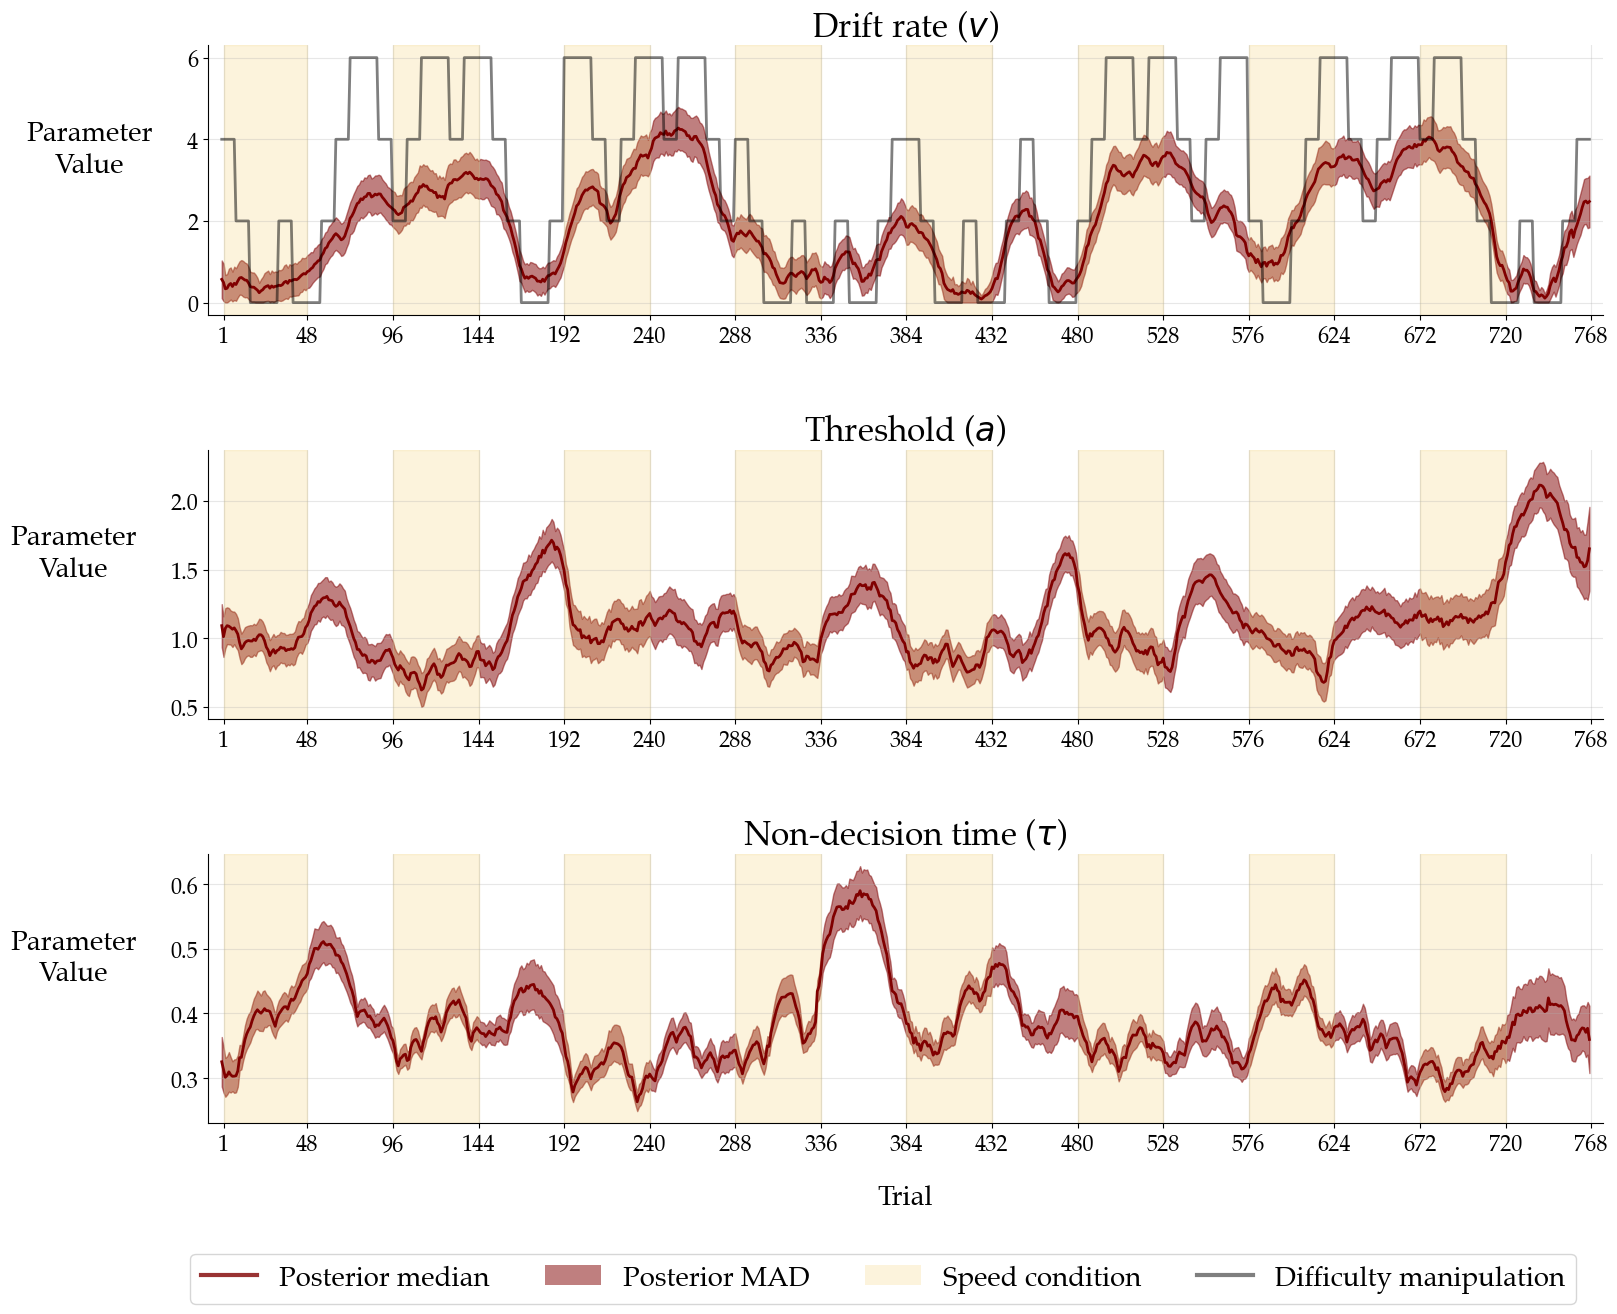

In [15]:
f = plot_parameter_trajectory(person_data, local_samples)

In [20]:
with open('data/winning_model_per_person.pkl', 'rb') as file:
    winning_model_per_person = pickle.load(file)

In [21]:
winning_model_per_person



array([2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2])

In [25]:
with open('data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)
with open('data/winning_model_per_person.pkl', 'rb') as file:
    winning_model_per_person = pickle.load(file)

In [27]:
setup = [get_setup(names, "smoothing") for names in model_names]
models = [model[0] for model in setup]

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from checkpoints/smoothing_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Performing 2 pilot runs with t

In [ ]:
NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

In [32]:
samples_per_model[0]['local_samples'][0].shape

(768, 2000, 3)

In [35]:
sub = 0
person_data = data.loc[data.id == sub+1]
grouped = data.groupby(['speed_condition', 'difficulty'])
person_summary = grouped.agg({
    'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
})
person_summary = person_summary.reset_index(drop=False)
person_summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']


# posterior re-simulation for all models
idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
summaries = []
summaries.append(person_summary)
for i, model in enumerate(models):
    pred_data = np.abs(
        model.likelihood(samples_per_model[i]['local_samples'][sub, :, idx, :])['sim_data']
        )
    pred_df = pd.DataFrame({
        'speed_condition': np.tile(person_data['speed_condition'], NUM_RESIMULATIONS),
        'difficulty': np.tile(person_data['difficulty'], NUM_RESIMULATIONS),
        'rt': pred_data.flatten(),
        })
    grouped = pred_df.groupby(['difficulty', 'speed_condition'])
    pred_summary = grouped.agg({
        'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    })
    pred_summary = pred_summary.reset_index(drop=False)
    pred_summary.columns = ['difficulty', 'speed_condition', 'median', 'mad']
    summaries.append(pred_summary)

In [55]:
np.arange(-0.6, 0.7, 0.2)

array([-6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  1.11022302e-16,
        2.00000000e-01,  4.00000000e-01,  6.00000000e-01])

In [69]:
BAR_WIDTH = np.arange(-0.6, 0.7, 0.2)
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
X_AXIS_VALUES = np.arange(4) * 2
LABELS = [
    'Empiric', 'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]
COLORS = [
    "black", "orange", "maroon", "#133a76", "green"
]
CONDITIONS = ["Accuracy Condition", "Speed Condition"]

In [81]:
summaries[0]["median"].min() - 0.1
summaries[0]["median"].max() + 0.3

0.717462649953086

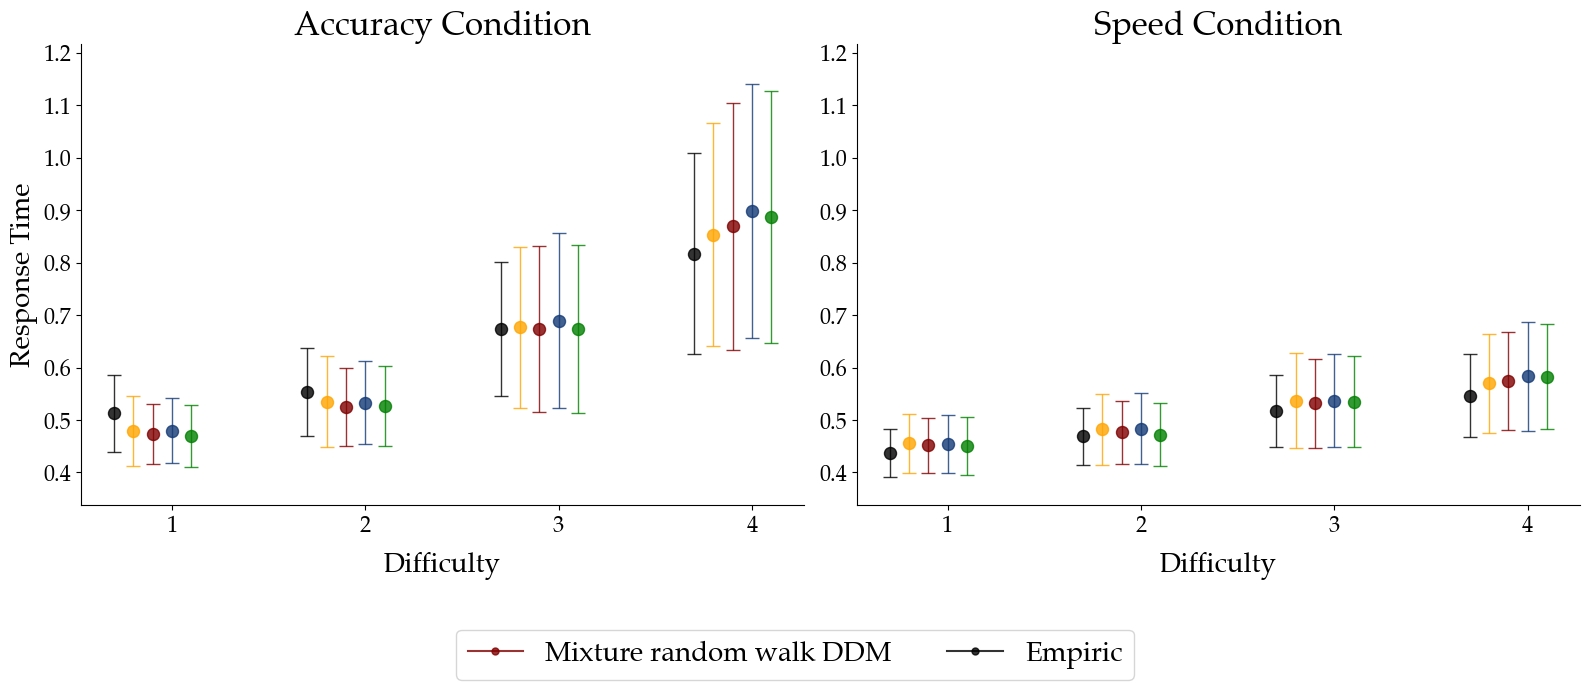

In [84]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))
for i, ax in enumerate(axarr.flat):
    for t in range(len(summaries)):
        ax.scatter(
            X_AXIS_VALUES + BAR_WIDTH[t],
            summaries[t].loc[summaries[t].speed_condition == i, 'median'],
            s=75, color=COLORS[t], alpha=0.8, label=LABELS[t]
        )

        ax.errorbar(
            X_AXIS_VALUES + BAR_WIDTH[t],
            summaries[t].loc[summaries[t].speed_condition == i, 'median'],
            yerr=summaries[t].loc[summaries[t].speed_condition == i, 'mad'],
            fmt='none', capsize=5, elinewidth=1,
            color=COLORS[t], alpha=0.8
            )

    ax.set_title(CONDITIONS[i], fontsize=FONT_SIZE_1)

    x_labels = ['1', '2', '3', '4']
    x_positions = [0, 2, 4, 6]
    ax.set_xticks(x_positions, x_labels)

    ax.set_ylim([
        summaries[0]["median"].min() - 0.1,
        summaries[0]["median"].max() + 0.4])

    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Response Time", fontsize=FONT_SIZE_2)

    ax.set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)

fig.subplots_adjust(hspace=0.5)
# legend
handles = [
    Line2D(
        xdata=[], ydata=[], marker='o', markersize=5,
        color='maroon', alpha=0.8,  label="Mixture random Walk DDM"
        ),
    Line2D(
        xdata=[], ydata=[], marker='o', markersize=5,
        color='black', alpha=0.8,  label="Empiric"
        )
    ]
fig.legend(
    handles,
    ["Mixture random walk DDM", "Empiric"],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.1),
    loc="center", ncol=2
    )
sns.despine()
fig.tight_layout()